In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx

In [2]:
def generate_ER_graph(N, p):
    x = np.random.uniform(size=(N, N))
    A = np.triu((x < p).astype(np.int32), 1)
    A = A + A.T 
    return A

In [3]:
class Graph(object):
    def __init__(self, A):
        assert A.shape == (len(A), len(A))
        np.testing.assert_array_equal(A, A.T)
        
        self.A = A
        self.D = A.sum(axis=1)
        G = nx.from_numpy_matrix(A)
        self.connected_components = list(nx.connected_components(G))

    def perpendicular_component(self, X):
        """Extract component perpendicular to the invariant space.

            The invariant space is U \otimes R^C where U is the eigenspace 
            associated with the smallest eigenvalue of the augmented normalized
            Laplacian. Specifically, U has the orthonormal basis (e_i)_{i=1, ..., A}
            defined by e_i = \tilde{D}delta_i. Here, A is the number of connected 
            components, \tilde{D}:=D + I, delta_{ij} = 1 if node j belongs to
            the i-th connected component.
        """

        assert len(X) == len(self.A)
        # e is the orthogonal basis of the eigenspace.
        # Use Gram-Schmidt
        for indices in self.connected_components:
            indices = list(indices)
            e = np.zeros(len(self.A), dtype=X.dtype)
            e[indices] = np.sqrt(self.D[indices] + 1)
            e_norm = np.linalg.norm(e)
            inner_prod = np.dot(e, X)
            X -= np.outer(e, inner_prod) / e_norm ** 2
        return X

    def compute_distance(self, X):
        X_perp = self.perpendicular_component(X)
        return np.linalg.norm(X_perp)

In [4]:
from lib.model import rsgcn

In [ ]:
plt.rcParams["font.size"] = 18

In [5]:
# from lib.dataset import normalization

# N = 1000
# p = 0.001
# A = generate_ER_graph(N, p)
# A_aug = normalization._augmented_normalize(A).toarray() 

# K = 10
# X = np.random.randint(K, size=(1, N,), dtype=np.int32)
# s = 1.

In [6]:
# L = 100
# C = 32
# model = rsgcn.RSGCN(out_dim=C, hidden_dim=C, n_layers=L, n_atom_types=K, dropout_ratio=0., no_readout=True, initial_weight_scale=s)

In [7]:
# _, ys = model(X, A_aug.astype(np.float32)[None, ...], True)

In [8]:
# G = Graph(A)

In [9]:
import scipy
from scipy.sparse import csr_matrix

def augmented_normalized_laplacian(A):
    A = A.astype(np.int32)
    N = len(A)
    A += np.eye(N, dtype=A.dtype)
    d = A.sum(axis=1)
    d_sqrt_inv = 1. / np.sqrt(d)
    D_sqrt_inv = np.diag(d_sqrt_inv)
    D_sqrt_inv = csr_matrix(D_sqrt_inv)
    A_normalized = D_sqrt_inv @ csr_matrix(A) @ D_sqrt_inv
    L_normalized = scipy.sparse.identity(N) - A_normalized
    return L_normalized

def eig(A):
    L = augmented_normalized_laplacian(A)
    eigs = np.linalg.eigvalsh(L.toarray())
    return eigs

In [10]:
# X = np.random.standard_normal(size=(N, C))
# X_perp = G.perpendicular_component(X)

# L_tilde = augmented_normalized_laplacian(G.A).toarray()
# for indices in G.connected_components:
#     indices = list(indices)
#     e = np.zeros(len(G.A), dtype=X.dtype)
#     e[indices] = np.sqrt(G.D[indices] + 1)
#     np.testing.assert_almost_equal(np.linalg.norm(np.dot(L_tilde, e)), 0.)
#     np.testing.assert_almost_equal(np.linalg.norm(np.dot(e, X_perp)), 0.)

In [11]:
# ds = np.array([G.compute_distance(y.array[0]) for y in ys])
# d_ratio_actual = ds / ds[0]

In [12]:
# lambda_ = 1 - eig(A)[len(G.connected_components)]
# d_ratio_expected = (s * lambda_) ** np.arange(L + 1)

In [13]:
# plt.plot(range(len(ds)), d_ratio_actual)
# plt.plot(range(len(ds)), d_ratio_expected)

In [34]:
from lib.dataset import normalization

def run(N, p, s, K=10, C=32, L=10):
    A = generate_ER_graph(N, p)
    A_aug_norm = normalization._augmented_normalize(A).toarray()   
    model = rsgcn.RSGCN(out_dim=C, hidden_dim=C, n_layers=L, n_atom_types=K,
                        dropout_ratio=0., no_readout=True, initial_weight_scale=s)
    X = np.random.randint(K, size=(1, N), dtype=np.int32)
    _, ys = model(X, A_aug_norm[None, ...], True)
    G = Graph(A)
    ds = np.array([G.compute_distance(y.array[0]) for y in ys])
    d_ratio_actual = ds / ds[0]
        
    lambda_ = 1 - eig(A)[len(G.connected_components)]
    d_ratio_expected = (s * lambda_) ** np.arange(L + 1)
    
    plt.title('p={}, s={}, lambda={:.3f}'.format(p, s, lambda_))
    plt.plot(range(len(ds)), np.log(d_ratio_actual), label='Actual', linewidth=3.)
    plt.plot(range(len(ds)), np.log(d_ratio_expected), label='Theorem', linewidth=3., linestyle='--')
    plt.legend()
    plt.xlabel('Layer Index')
    plt.ylabel('Log Relative Distance')

In [15]:
# run(1000, 0.001, .3, L=10)

In [16]:
# run(1000, 0.001, .6, L=10)

In [17]:
# run(1000, 0.001, 1., L=10)

In [18]:
# run(1000, 0.001, 1.1, L=10)

In [19]:
# run(1000, 0.001, 1.2, L=10)

In [20]:
# run(1000, 0.001, 2., L=10)

In [21]:
# run(1000, 0.001, 3., L=10)

In [22]:
# run(1000, 0.01, .1)

In [23]:
# run(1000, 0.01, 1.)

In [24]:
# run(1000, 0.01, 1.6)

In [25]:
# run(1000, 0.01, 3.)

In [26]:
# run(1000, 0.01, 10.)

In [27]:
# run(1000, 0.01, 20.)

In [28]:
# N = 1000
# p = [.0001, .001, .01, .1, .9]
# s = [.001, .01, .1, 1., 10.]

# plt.figure(figsize=(5 * len(p), 5 * len(s)))
# for i in range(len(p)):
#     for j in range(len(s)):
#         print(p[i], s[j])
#         plt.subplot(len(p), len(s), i * len(p) + j + 1)
#         run(N, p[i], s[j])
# plt.tight_layout()
# plt.savefig('d_m_comparison_all.pdf')

0.01 0.1
0.01 1.0
0.01 10.0
0.1 0.1
0.1 1.0
0.1 10.0
0.9 0.1
0.9 1.0
0.9 10.0


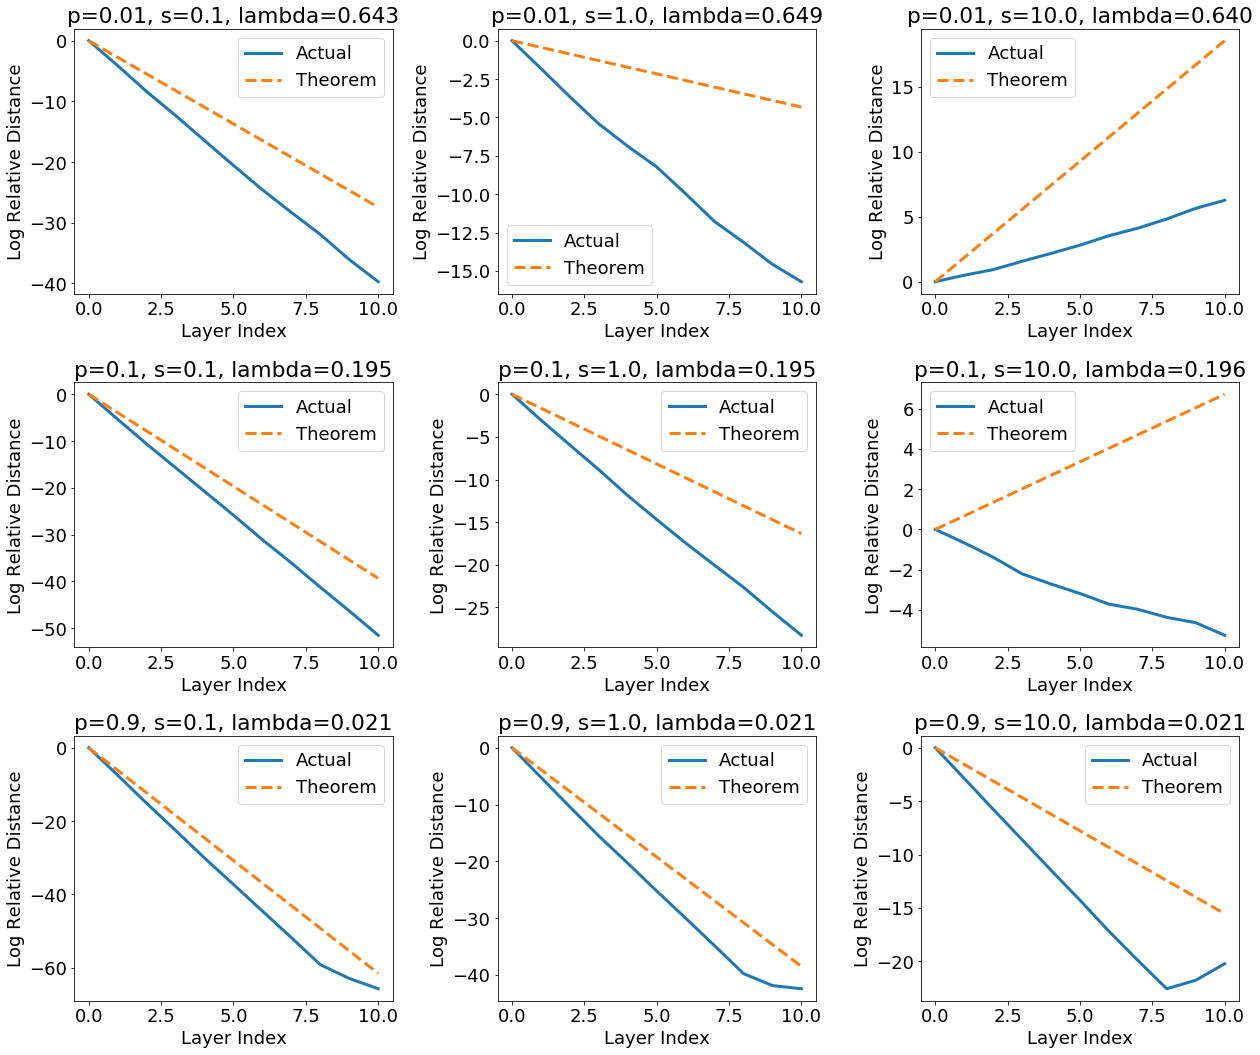

In [40]:
N = 1000
p = [.01, .1, .9]
s = [.1, 1., 10.]

plt.figure(figsize=(6 * len(s), 5 * len(p)))
for i in range(len(p)):
    for j in range(len(s)):
        print(p[i], s[j])
        plt.subplot(len(p), len(s), i * len(p) + j + 1)
        run(N, p[i], s[j])
plt.tight_layout()
plt.savefig('d_m_comparison_all.pdf')

In [30]:
# N = 1000
# p = [.1, .9]
# s = [.1, 1., 10.]

# plt.rcParams["font.size"] = 13

# plt.figure(figsize=(5 * len(s), 5 * len(p)))
# for i in range(len(p)):
#     for j in range(len(s)):
#         print(p[i], s[j])
#         plt.subplot(len(p), len(s), i * len(s) + j + 1)
#         run(N, p[i], s[j])
# plt.tight_layout()
# plt.savefig('d_m_comparison.pdf')

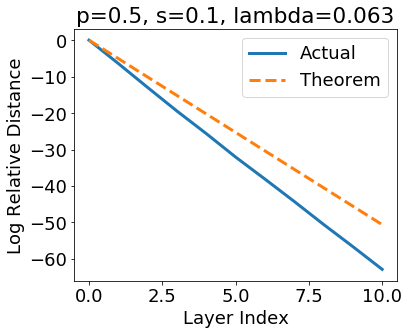

In [37]:
N = 1000
p = .5
s = .1
plt.figure(figsize=(6, 5))
run(N, p, s)
plt.tight_layout()
plt.savefig('d_m_small_s_lambda.pdf')

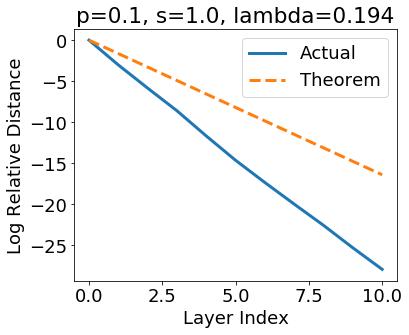

In [36]:
N = 1000
p = .1
s = 1.
plt.figure(figsize=(6, 5))
run(N, p, s)
plt.tight_layout()
plt.savefig('d_m_medium_s_lambda.pdf')

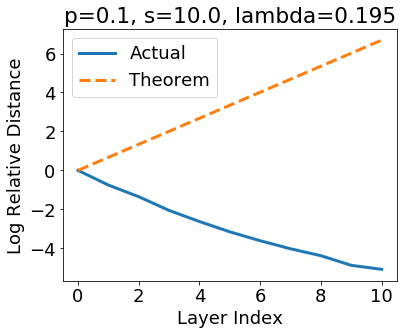

In [35]:
N = 1000
p = .1
s = 10.
plt.figure(figsize=(6, 5))
run(N, p, s)
plt.tight_layout()
plt.savefig('d_m_large_s_lambda.pdf')